<a href="https://colab.research.google.com/github/PhilipMathieu/access/blob/main/notebooks/0d%20portland_greenspace_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary libraries
!pip install --upgrade geopandas contextily osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
import os.path
import urllib.parse

import contextily as cx
import geopandas as gpd
import matplotlib as mpl
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, Point, Polygon

ox.settings.cache_folder = "../cache/"
from tqdm.autonotebook import tqdm

tqdm.pandas()

%matplotlib inline
mpl.rcParams["figure.figsize"] = (16, 9)
mpl.rcParams["savefig.dpi"] = 300

<ipython-input-2-77e62d5a8d59>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Set Boundary

Load a shapefile containing the boundary of the city of Portland, ME. This will be used to determine which Census blocks to include.

In [3]:
portland_boundary = gpd.read_file(
    "https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_Town_and_Townships_Boundary_Polygons_Dissolved/FeatureServer/0/query?where=TOWN%20%3D%20'PORTLAND'&outFields=*&outSR=4269&f=json"
)

## Load census blocks

In [4]:
!wget -nc https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK20/tl_2020_23_tabblock20.zip -P ../data/blocks/

File ‘../data/blocks/tl_2020_23_tabblock20.zip’ already there; not retrieving.



In [5]:
blocks = (
    gpd.read_file("../data/blocks/tl_2020_23_tabblock20.zip")
    .set_index("GEOID20")
    .clip(portland_boundary)
    .to_crs("EPSG:3857")
)

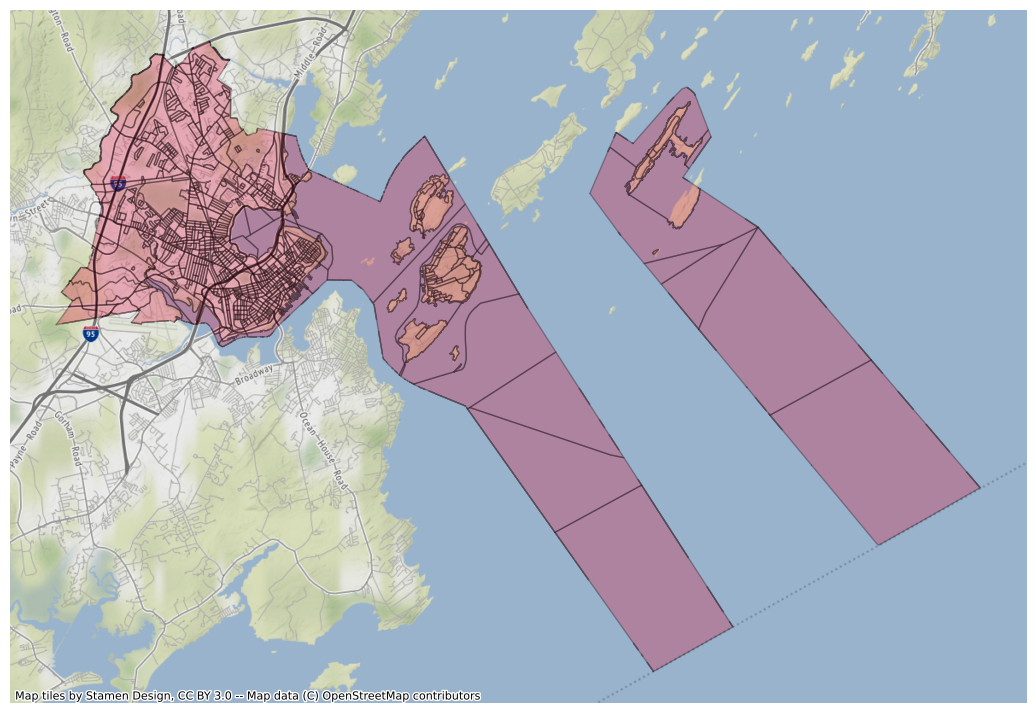

In [6]:
ax = blocks.plot(alpha=0.3, facecolor="crimson", edgecolor="k")
ax.axis("off")
cx.add_basemap(ax)

Because this approach assumes walking distance, results aren't valid for "blocks" that are primarily areas of water. We can filter these out using the 'AWATER20' column.

In [7]:
# manually remove islands
blocks = blocks[blocks["AWATER20"] == 0]

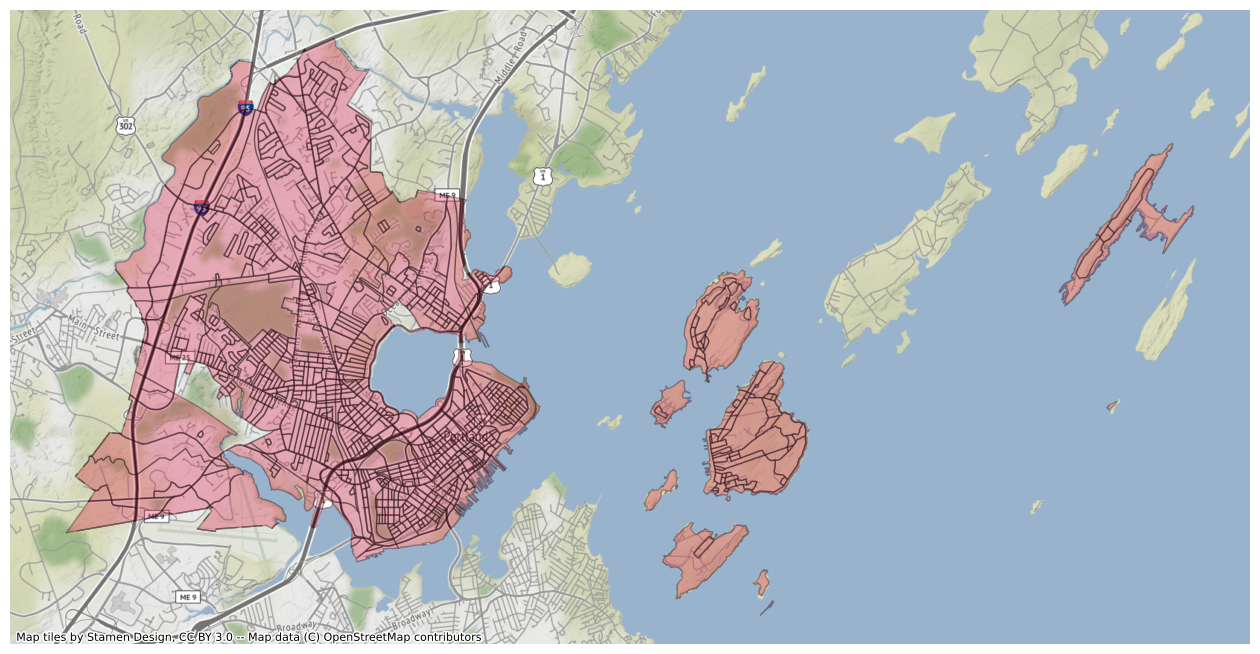

In [44]:
ax = blocks.plot(alpha=0.3, facecolor="crimson", edgecolor="k")
ax.axis("off")
cx.add_basemap(ax)
# plt.savefig('figs/blocks.png')

## Download and prep the street network

This is usually the most time-consuming step, as the size of the graph could be arbitrarily large. To speed up computation, download the graph separately and load it from local storage.

In [9]:
filepath = "../data/graphs/greater_portland.graphml"

if os.path.isfile(filepath):
    # load from file
    G = ox.load_graphml(filepath)
else:
    # download the street network
    bbox = blocks.to_crs("EPSG:4326").geometry.unary_union.envelope.bounds
    buffer = 0.05  # unit is lat/lon degrees
    network_type = "walk"
    G = ox.graph_from_bbox(
        bbox[3] + buffer,
        bbox[1] - buffer,
        bbox[2] + buffer,
        bbox[0] - buffer,
        network_type=network_type,
    )
    ox.save_graphml(G, filepath)

G = ox.project_graph(G, "EPSG:3857")  # project the graph to UTM for this zone

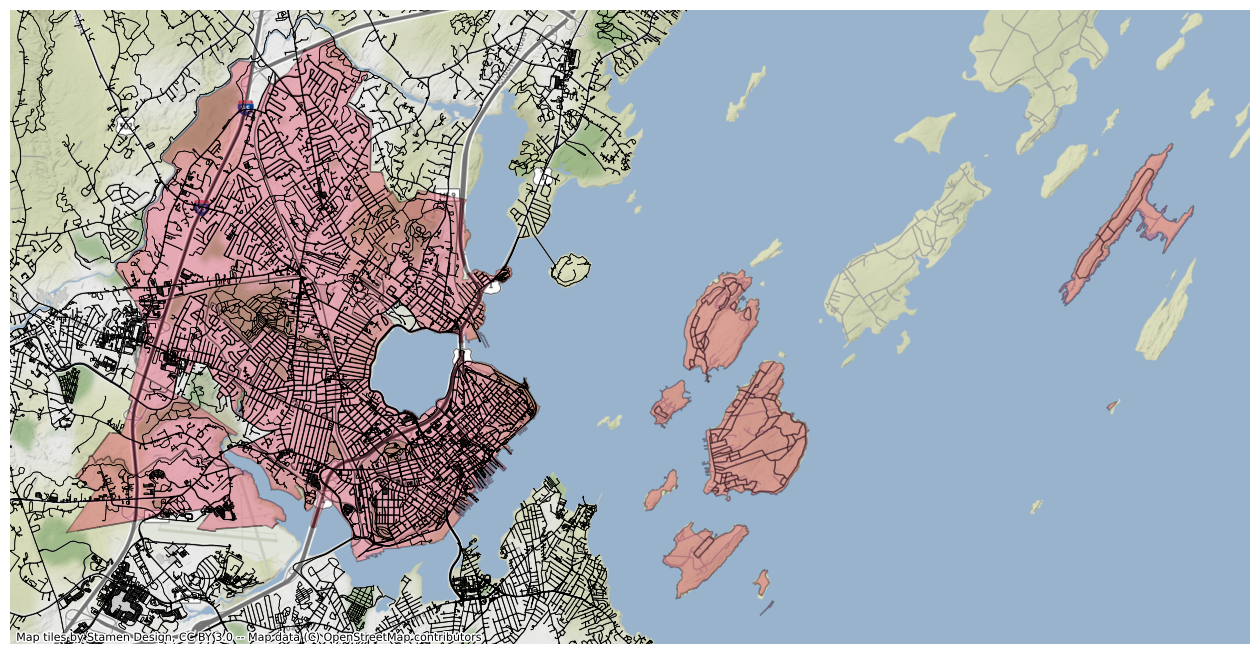

In [43]:
ax = blocks.plot(alpha=0.3, facecolor="crimson", edgecolor="k")
ax.axis("off")
bbox_nsew = tuple(reversed(ax.get_xlim() + ax.get_ylim()))
ox.plot_graph(
    G,
    ax=ax,
    bgcolor=None,
    show=False,
    close=False,
    node_size=1,
    bbox=bbox_nsew,
    node_color="k",
    edge_color="k",
    edge_linewidth=0.5,
)
cx.add_basemap(ax)
# plt.savefig('figs/roads.png')

For each census tract, we need to find the closest node on the graph. (This will allow us to compute distance entirely in terms of graph distance, as opposed to relying on spatial projections which are both slower and possibly less accurate.)

Median Distance:  78 m


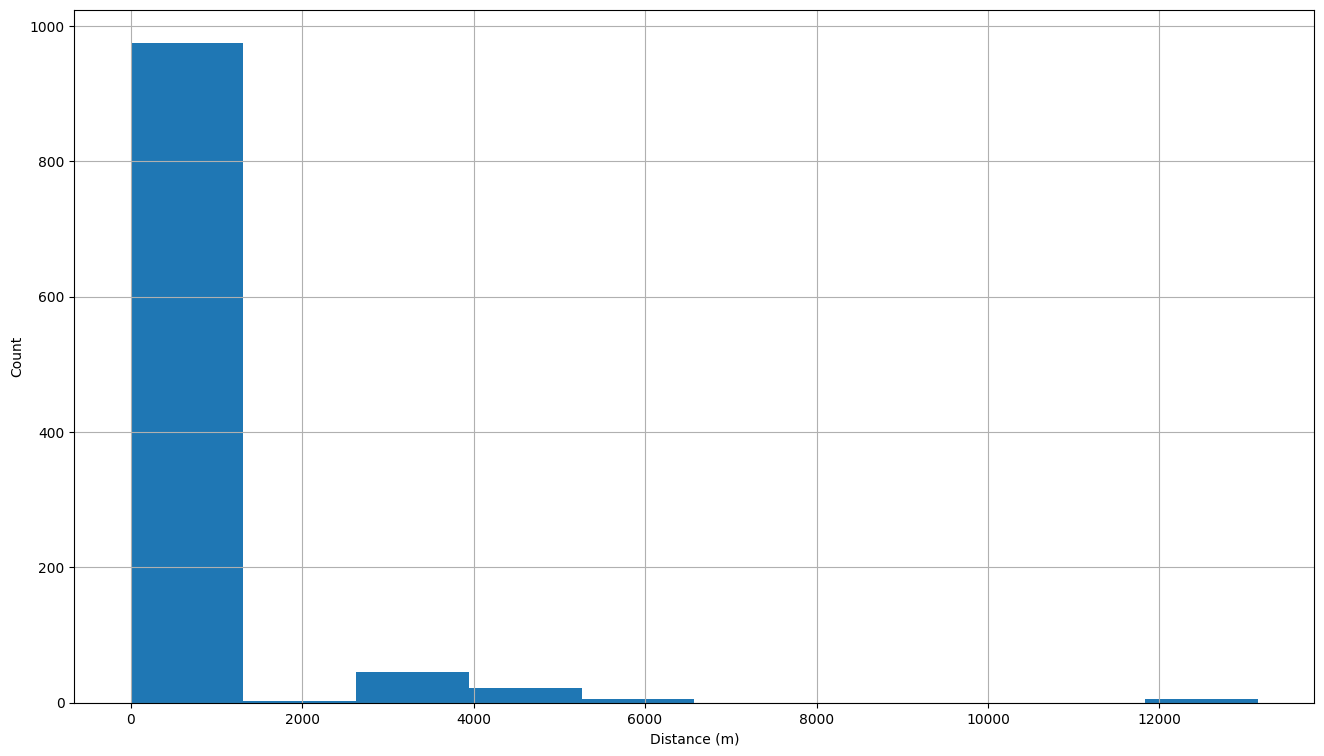

In [11]:
# use a spatial index to efficiently find nearest nodes
gdf_nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
blocks["osmid"] = gdf_nodes.loc[gdf_nodes.sindex.nearest(blocks.centroid)[1]]["osmid"].values
center_nodes_gdf = ox.graph_to_gdfs(G, edges=False).loc[blocks["osmid"]]

# verify that nodes are reasonably close
center_nodes_gdf["distance"] = center_nodes_gdf.distance(blocks.centroid, align=False)
ax = center_nodes_gdf["distance"].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_gdf['distance'].median():3.0f} m")

There's clearly an issue here. The median distance is just 79 m, but there are several nodes with distances over a kilometer. Further investigation would show that this happens when the islands are mapped to nodes on the mainland. To dodge this issue, we can filter nodes where the distance is too high (say, >500m)

In [12]:
center_nodes_gdf = center_nodes_gdf[center_nodes_gdf["distance"] < 500]

Median Distance:  72 m


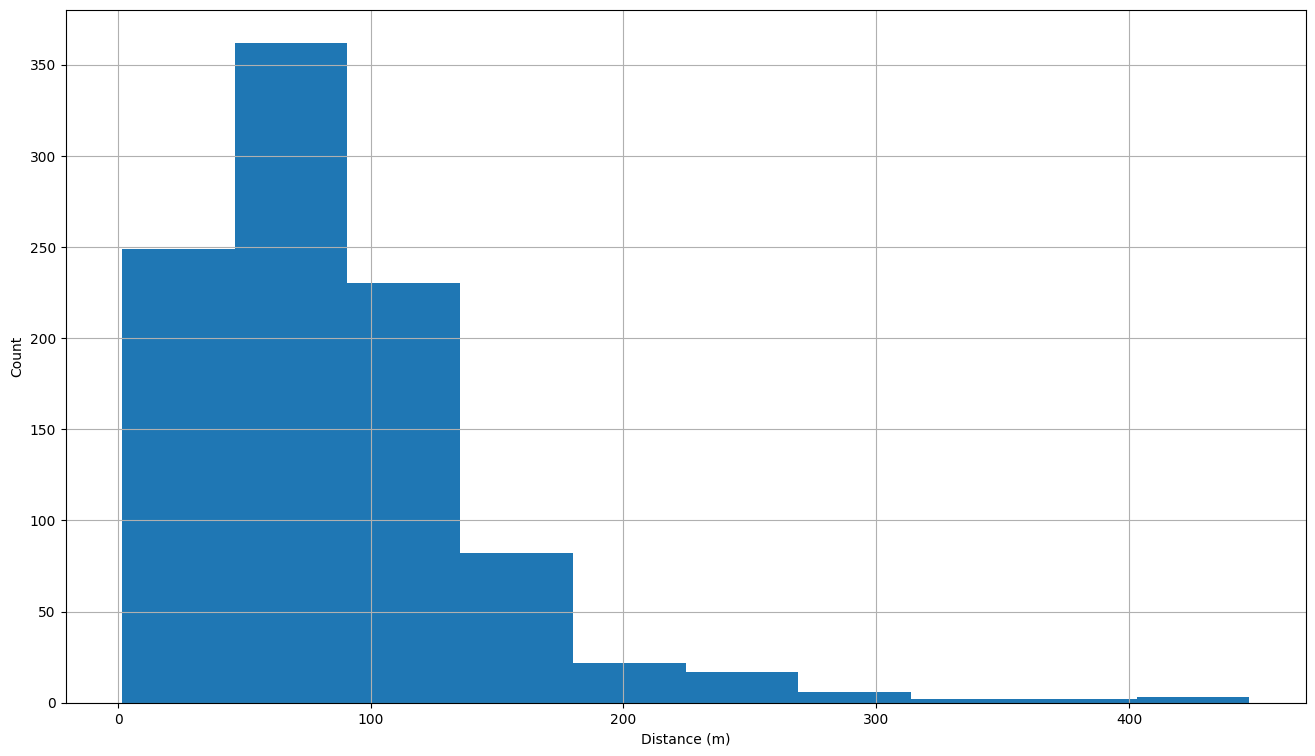

In [13]:
ax = center_nodes_gdf["distance"].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_gdf['distance'].median():3.0f} m")

## Plot nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, 30, 45, and 60 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [14]:
# configure trip times and travel speed
trip_times = [5, 10, 15, 20, 30, 45, 60]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [15]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [16]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

Processing Node 7891738693


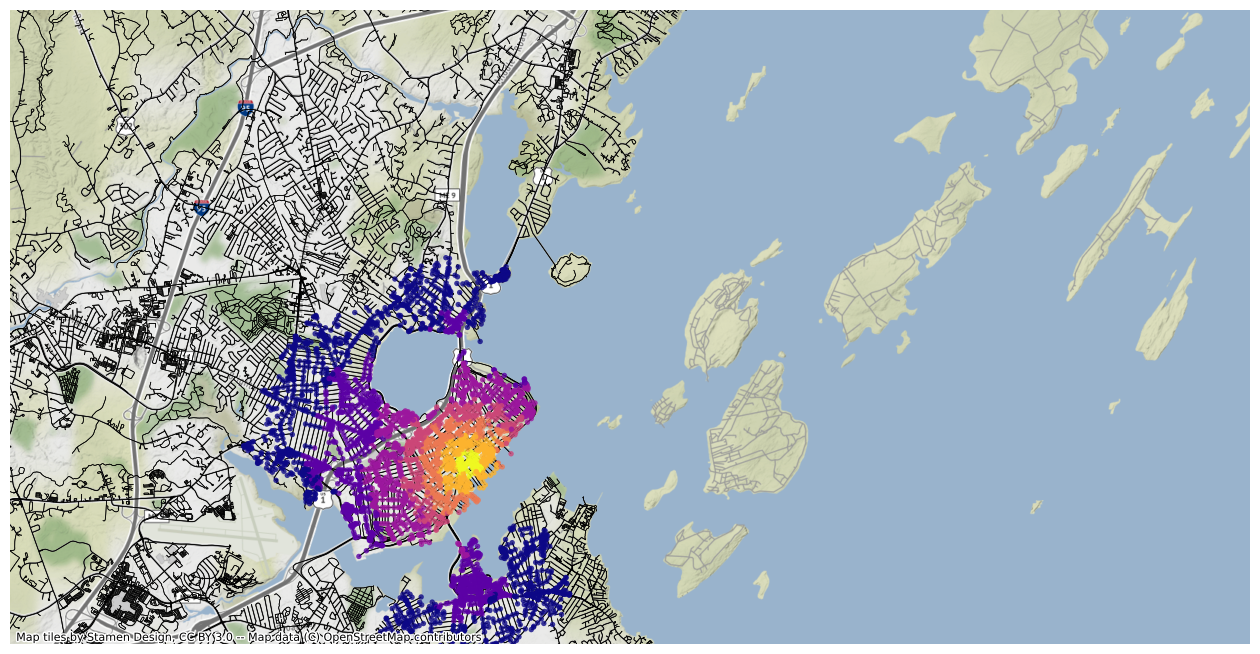

In [42]:
center_node = center_nodes_gdf.index[42]
print(f"Processing Node {center_node}")
# color the nodes according to isochrone then plot the street network
node_times = {}
node_colors = {}
# loop over allowed trip times
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors, strict=False):
    # find subgraph from center node
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # color nodes according to the isoline
    for node in subgraph.nodes():
        node_times[node] = trip_time
        node_colors[node] = color
# set node size and color for unreachable nodes
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
# show the result
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_color=nc,
    node_size=ns,
    bbox=bbox_nsew,
    edge_color="k",
    edge_linewidth=0.5,
    node_alpha=0.8,
    show=False,
    close=False,
    figsize=(16, 9),
    dpi=300,
)
cx.add_basemap(ax)
# plt.savefig('figs/node_distance.png')

## Plot the time-distances as isochrones

Rather than just labelling the nodes by walk time, it's convenient to generate convex polygons that approximate the area within each walk time. This will facilitate spatial analysis later on.

In [18]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=5, node_buff=0, infill=True)
iso_poly_gdf = gpd.GeoDataFrame.from_dict(
    {"trip_times": trip_times, "geometry": isochrone_polys}, crs="EPSG:3857"
)

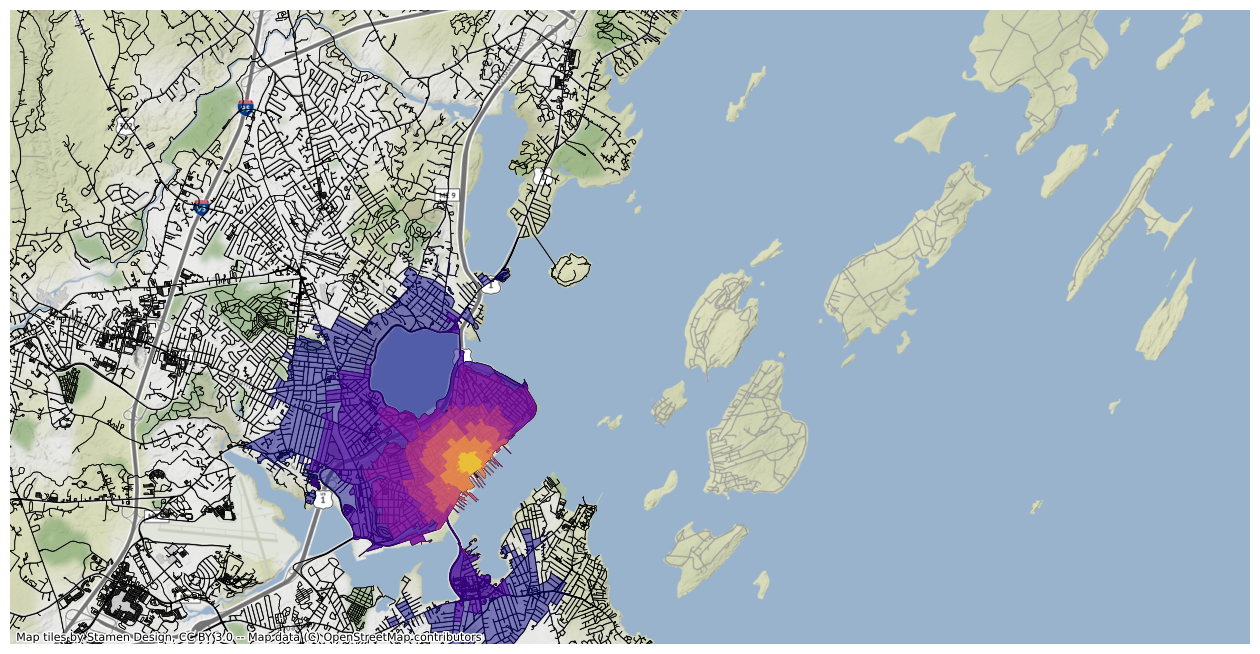

In [41]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_size=0,
    bbox=bbox_nsew,
    edge_color="k",
    edge_linewidth=0.5,
    show=False,
    close=False,
    figsize=(16, 9),
    dpi=300,
)
iso_poly_gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.5)
cx.add_basemap(ax)
# plt.savefig('figs/poly_dist.png')

## Load Conserved Lands based on bounding box
The next step is to use the walk time polygons to find conserved lands within each walk time. We start by getting all conserved lands in and near our isochrones.

In [20]:
# make an ESRI geometry JSON object from the bounding box
# https://developers.arcgis.com/rest/services-reference/enterprise/query-map-service-layer-.htm
bbox_json = json.dumps({"points": iso_poly_gdf.geometry.unary_union.envelope.exterior.coords[:]})
bbox_json

'{"points": [[-7826492.586125728, 5407081.074701348], [-7818116.34903547, 5407081.074701348], [-7818116.34903547, 5417780.445810881], [-7826492.586125728, 5417780.445810881], [-7826492.586125728, 5407081.074701348]]}'

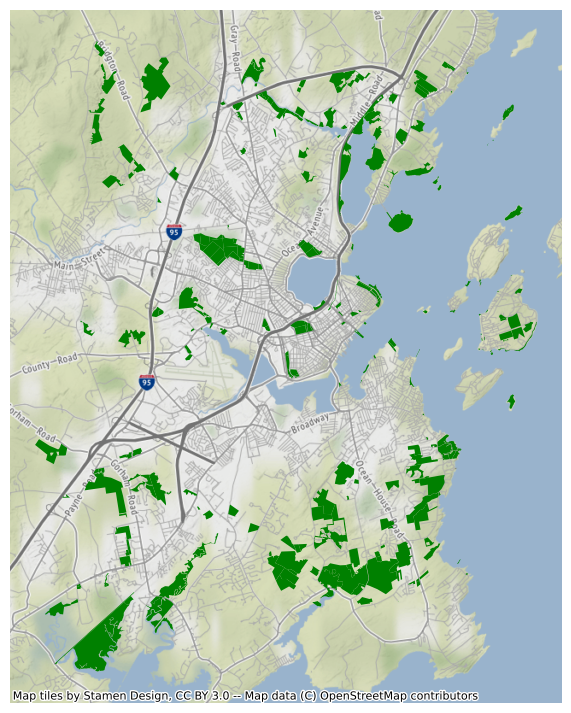

In [21]:
# get all conserved parcels within 3 mile radius of this polygon
lands = gpd.read_file(
    "https://gis.maine.gov/arcgis/rest/services/acf/Conserved_Lands/MapServer/0/query?"
    + "where=&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry="
    + urllib.parse.quote(bbox_json)
    + "&geometryType=esriGeometryMultipoint&inSR=3857&spatialRel=esriSpatialRelEnvelopeIntersects&"
    + "distance="
    + str(3)
    + "&units=esriSRUnit_StatuteMile&outFields=*&returnGeometry=true&returnTrueCurves=false&outSR=3857&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&sqlFormat=none&featureEncoding=esriDefault&f=geojson"
)
ax = lands.plot(color="g")
ax.axis("off")
cx.add_basemap(ax)

## Identify Conserved Lands within Isochrones
Here again we map each land to its centroid, then each centroid to the nearest graph node.

In [22]:
# use a spatial index to efficiently find nearest nodes
gdf_nodes_cl = ox.graph_to_gdfs(G, edges=False).reset_index()
# find the nearest node and retrieve a list of osmids
lands["osmid"] = gdf_nodes_cl.loc[gdf_nodes_cl.sindex.nearest(lands.centroid)[1]]["osmid"].values
center_nodes_cl_gdf = ox.graph_to_gdfs(G, edges=False).loc[lands["osmid"].tolist()]

Median Distance: 110 m


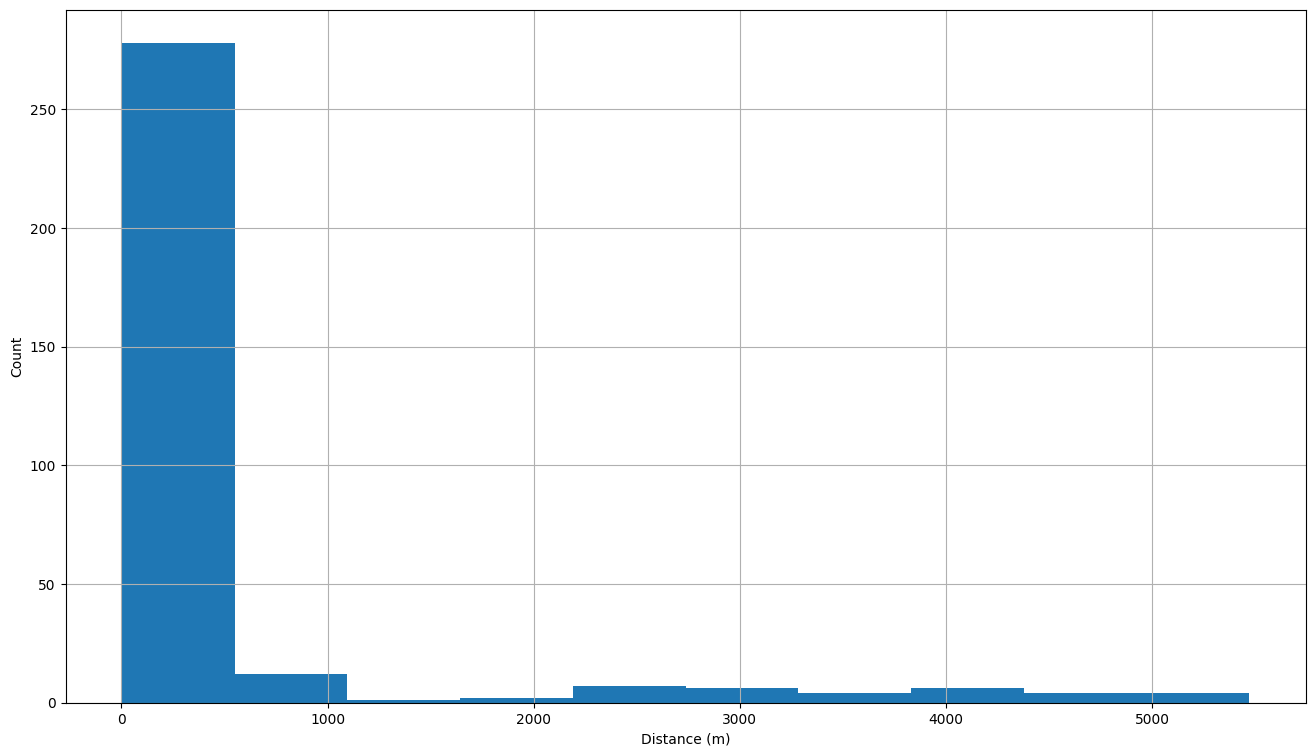

In [23]:
# verify that nodes are reasonably close
center_nodes_cl_gdf["distance"] = center_nodes_cl_gdf.distance(lands.centroid, align=False)
ax = center_nodes_cl_gdf["distance"].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_cl_gdf['distance'].median():3.0f} m")

As with before, we will drop nodes that are too far from the actual centers.

In [24]:
lands = lands[center_nodes_cl_gdf.reset_index()["distance"] < 500]
center_nodes_cl_gdf = center_nodes_cl_gdf[center_nodes_cl_gdf["distance"] < 500]

Median Distance:  93 m


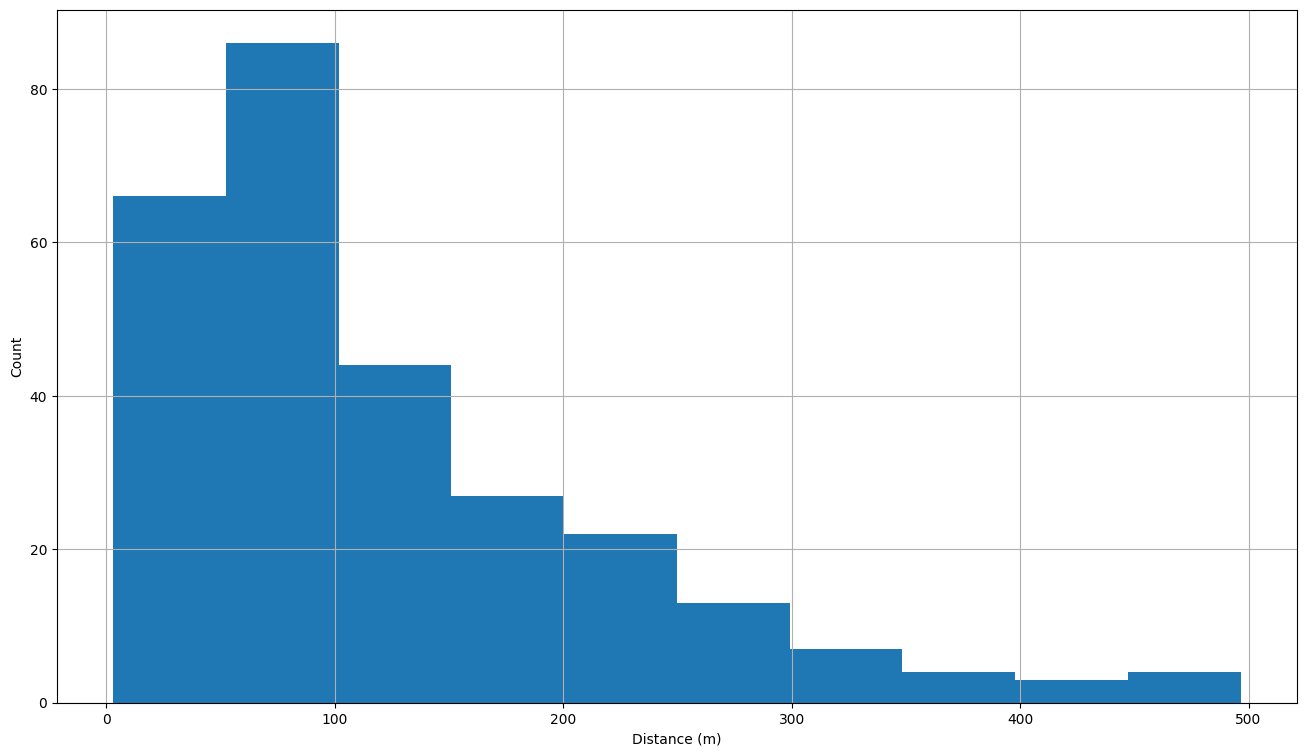

In [25]:
# verify that nodes are reasonably close
ax = center_nodes_cl_gdf["distance"].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_cl_gdf['distance'].median():3.0f} m")

## Calculating Trip Times
As an example, we can take the node we plotted above and look at all the conserved land within different walking distances.

In [26]:
# create a dataframe with the points
lands_points = lands.copy()
lands_points["trip_times"] = [
    node_times[node] if node in node_times else None for node in lands["osmid"].tolist()
]
lands_colors = [
    node_colors[node] if node in node_colors else "none" for node in lands["osmid"].tolist()
]
lands_edgecolors = ["green" if node in node_colors else "none" for node in lands["osmid"].tolist()]

How many conserved lands are within each trip time?

In [27]:
# calculate the number of lands within each trip time
lands_points.groupby("trip_times")["OBJECTID"].count()

trip_times
10.0     2
15.0     4
20.0     8
30.0    21
45.0    14
60.0    15
Name: OBJECTID, dtype: int64

What area of conserved land is within each trip time?

In [28]:
lands_points.groupby("trip_times")["CALC_AC"].sum()

trip_times
10.0     3.825021
15.0    11.338001
20.0    18.521430
30.0    89.091334
45.0    49.263614
60.0    95.606561
Name: CALC_AC, dtype: float64

Where are these properties on the map?

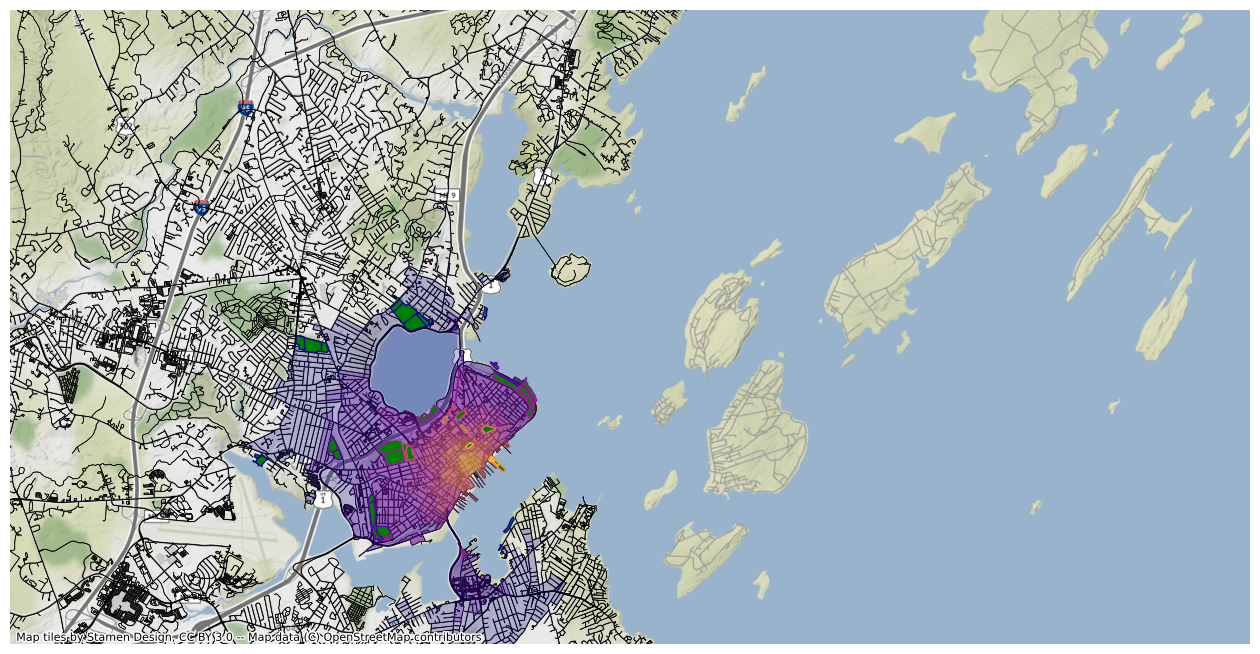

In [40]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_size=0,
    bbox=bbox_nsew,
    edge_color="k",
    edge_linewidth=0.5,
    show=False,
    close=False,
    figsize=(16, 9),
    dpi=300,
)
iso_poly_gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.25)
# note - we flipped "color" and "edgecolor" intentionally to provide better contrast
lands_points.plot(ax=ax, color=lands_edgecolors, edgecolor=lands_colors)
cx.add_basemap(ax)
# plt.savefig('figs/conserved_dist.png')

List the properties by walk time

In [30]:
lands_points.sort_values("trip_times")

created_user   created_date last_edited_user  last_edited_date  \
175  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
236  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
106  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
58   MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
40   MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
..           ...            ...              ...               ...   
317  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
319  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
320  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
322  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
323  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   

            PROJECT     PARCEL_NAME                    DESIGNATION CONS1_TYPE  \
175             NaN       028  B001  Miscellaneous Municipal Lands        Fee   
236  Bell Buoy Park  Bell Buoy Park                            NaN        Fee   
106             NaN       024  C010  Miscellaneous Municipal Lands        Fee   
58              NaN       022  F023  Miscellaneous Municipal Lands        Fee   
40              NaN       020  A001  Miscellaneous Municipal Lands        Fee   
..              ...             ...                            ...        ...   
317             NaN       282  A002  Miscellaneous Municipal Lands        Fee   
319   Fort Williams    U48001000000  Miscellaneous Municipal Lands        Fee   
320             NaN       281  A001  Miscellaneous Municipal Lands        Fee   
322             NaN             NaN                            NaN        Fee   
323                         R059025  Miscellaneous Municipal Lands        Fee   

                     HOLD1_NAME HOLD1_TYPE  ... CL_UNIQUEID  \
175  Maine Minor Civil Division  Municipal  ...       10522   
236  Maine Minor Civil Division  Municipal  ...        8993   
106  Maine Minor Civil Division  Municipal  ...       10516   
58   Maine Minor Civil Division  Municipal  ...       10521   
40   Maine Minor Civil Division  Municipal  ...       10513   
..                          ...        ...  ...         ...   
317  Maine Minor Civil Division  Municipal  ...       10609   
319  Maine Minor Civil Division  Municipal  ...        9961   
320  Maine Minor Civil Division  Municipal  ...       10608   
322  Maine Minor Civil Division  Municipal  ...        4218   
323  Maine Minor Civil Division  Municipal  ...       10181   

                                   GlobalID TAX_MAP_TOWN  TAX_MAP_BOOK_LOT  \
175  {6E9C0553-AD91-4B17-A562-7BEC8D0F69E6}          NaN               NaN   
236  {0B096756-D19C-45EF-B356-FB21A3C0692C}          NaN               NaN   
106  {0BD95A90-DE8B-41EC-B2EE-6DEA282F1CBA}          NaN               NaN   
58   {41EE7595-E613-4BE2-94CB-B60A3137A80D}          NaN               NaN   
40   {0505AF6E-DD9A-4C3F-96F9-BC64B02A36EC}          NaN               NaN   
..                                      ...          ...               ...   
317  {E0066CF6-D65C-41D5-88E3-DFBFA5B75423}          NaN               NaN   
319  {01E20C24-6B30-41C6-B58F-7D886A7A9B0E}          NaN               NaN   
320  {7F4FB83F-FAC8-4F68-9525-4DDD359C842A}          NaN               NaN   
322  {527C4C0E-CFB0-4B95-879A-35287178581C}          NaN               NaN   
323  {44CF7C62-0698-4C18-A679-BB1499C0F2D1}          NaN               NaN   

    OBJECTID  Shape.STArea()  Shape.STLength()  \
175    19939     7457.705535        370.632235   
236    18725     8021.603977        856.804240   
106    16778     4833.726576        355.745577   
58     14785     5962.906720        431.005304   
40     13279    21187.863505        661.594419   
..       ...             ...               ...   
317    17959   145493.773467       1560.240402   
319    17106      464.497216         86.696565   
320    19725    34859.407828       1139.155433

## Putting it all together

In [31]:
land_nodes = lands["osmid"].values


def get_lands(center_node=102322137):
    for trip_time in trip_times:
        # find subgraph from center node
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
        # set node distance to current trip_time
        for node in subgraph.nodes():
            if node in land_nodes:
                return trip_time
    return None


center_nodes_gdf["min_time"] = center_nodes_gdf.index.to_series().progress_apply(get_lands)

  0%|          | 0/975 [00:00<?, ?it/s]

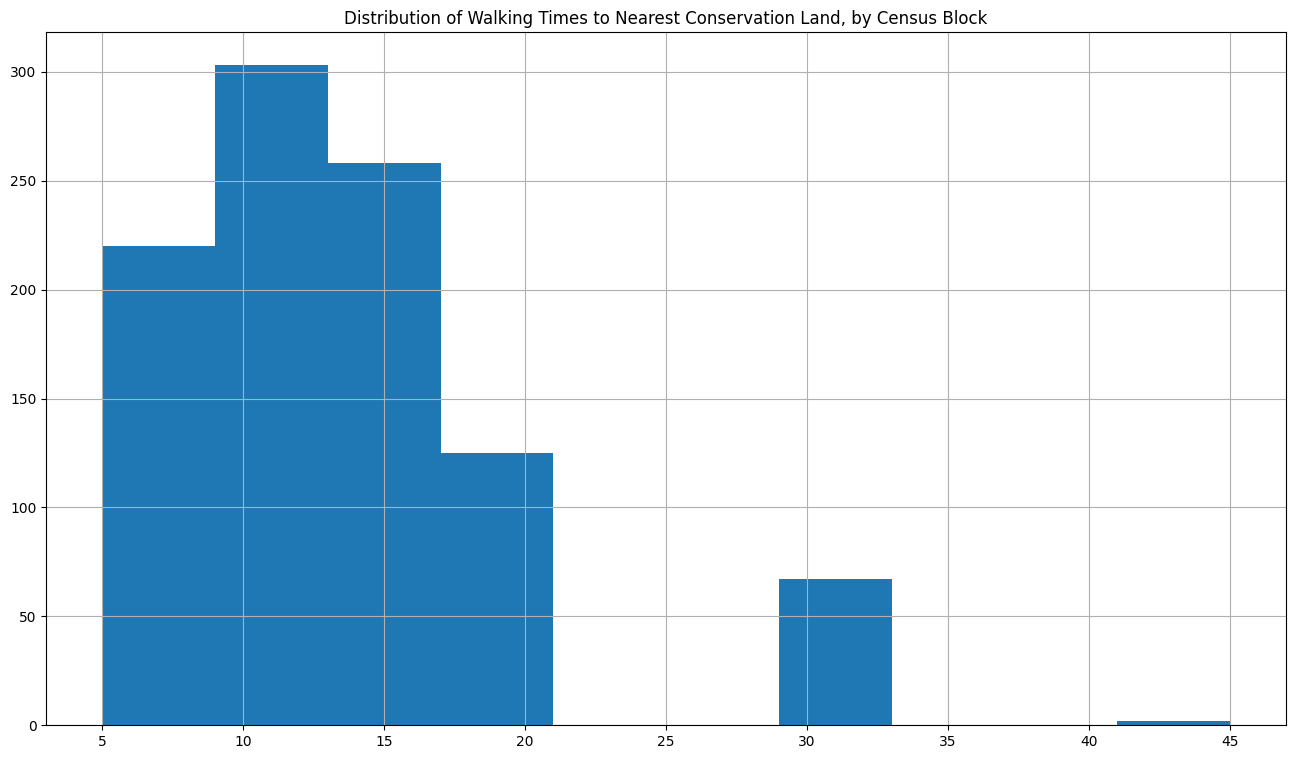

In [36]:
ax = center_nodes_gdf["min_time"].hist()
ax.set_title("Distribution of Walking Times to Nearest Conservation Land, by Census Block")
# plt.savefig('figs/block_hist.png')

In [37]:
blocks_merge = blocks.merge(center_nodes_gdf["min_time"], left_on="osmid", right_index=True)

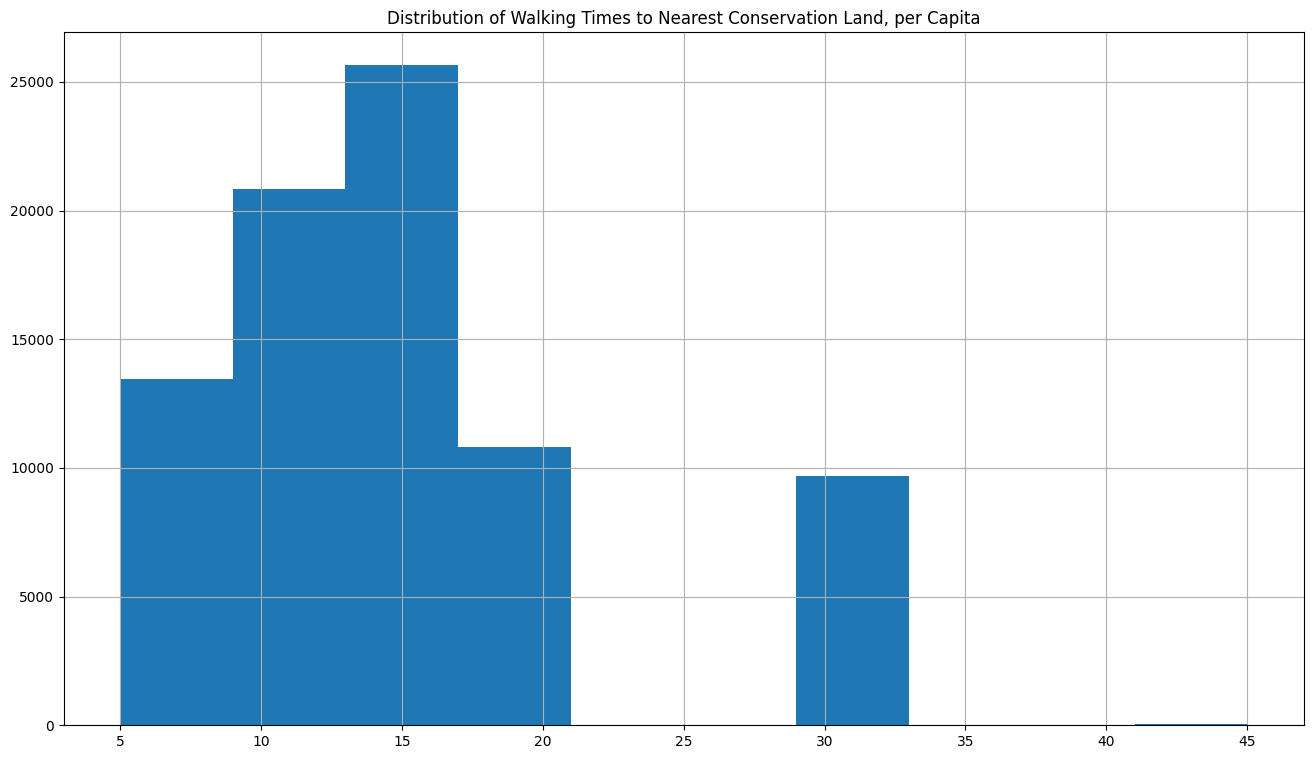

In [38]:
ax = blocks_merge["min_time"].hist(weights=blocks_merge["POP20"])
ax.set_title("Distribution of Walking Times to Nearest Conservation Land, per Capita")
# plt.savefig('figs/pop_hist.png')

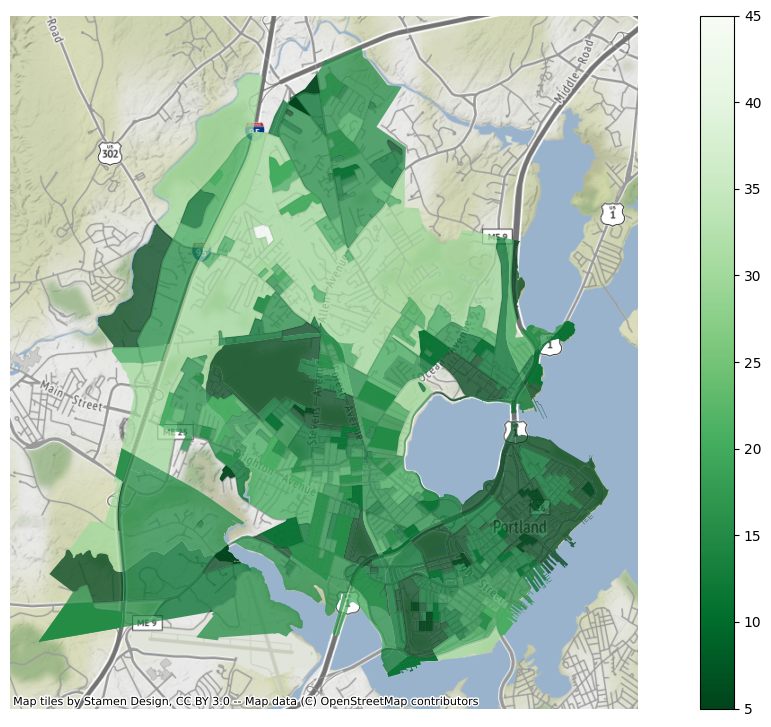

In [39]:
ax = blocks_merge.plot("min_time", legend=True, cmap="Greens_r", alpha=0.75)
ax.axis("off")
cx.add_basemap(ax)
# plt.savefig('figs/choropleth.png')